# Convolutional Autoencoder (AE) and Spatial filters for covid chest x-ray denoising

## Set up the enviroment

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Import necessary libraries and packages

In [ ]:
#Import libraries & packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
import random
from google.colab.patches import cv2_imshow
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from PIL import Image, ImageOps
from sklearn.utils import shuffle
import pathlib
import os
import cv2
import math
from math import log10, sqrt
import glob
from matplotlib import pyplot as plt

import time

from sklearn.model_selection import train_test_split
import skimage
from skimage import data
from skimage import util
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk
from scipy import ndimage, misc
import scipy.misc
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers 
import tensorflow as tf
from tensorflow import distribute
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adadelta, RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, Conv2D, Reshape, Conv2DTranspose
#from tensorflow.keras.layers import Dense, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error, mean_squared_error, normalized_root_mse

## Connect google colab with drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Read the images form the directory and load them into the computing platform

In [ ]:
images = sorted(os.listdir('gdrive/My Drive/images/chestxray'))
image_data = []

for im in images:
  img = image.load_img('gdrive/My Drive/images/chestxray/'+im, target_size = (128,128), color_mode = 'grayscale')
  img = image.img_to_array(img)
  img = img/255
  image_data.append(img)

image_dataset = np.array(image_data)

### Display the images from the dataset

In [ ]:
#Subplotting images
def plot_img(dataset):
  f, ax = plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(128, 128), cmap='gray')
  plt.show()

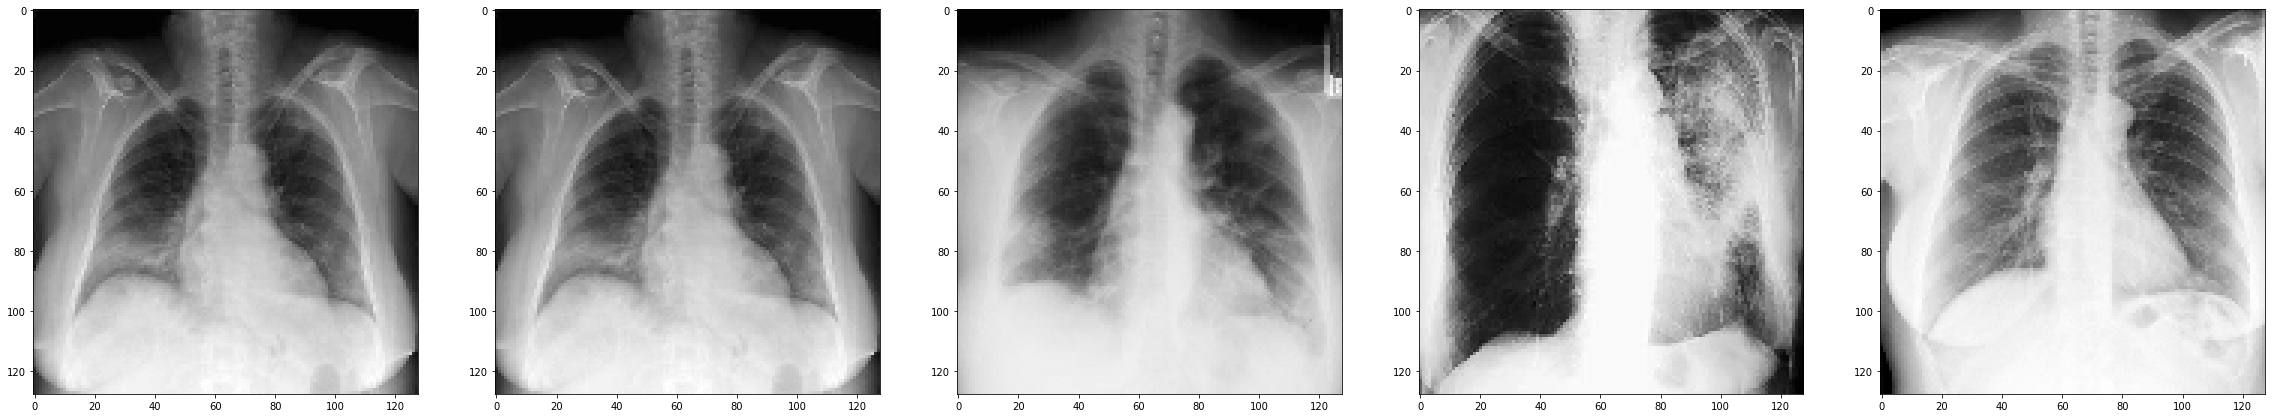

In [ ]:
plot_img(image_dataset)

## Load, rescale an image and convert into NumPy array

### Display the original and resized image

---------------------------------
| original image size: 447 x 418 |
---------------------------------


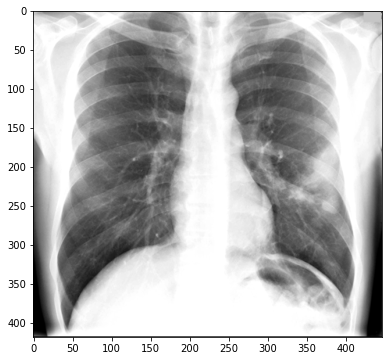

-----------------------------
| new image size: 256 x 256 |
-----------------------------


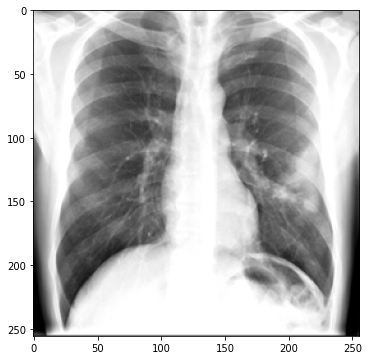

In [ ]:
image_data = Image.open('/content/gdrive/My Drive/images/chestxray/000001-4.png').convert('L')

#Subplotting images
width, height = image_data.size
plt.subplots(figsize=(10, 6))

print('---------------------------------')
print('| original image size: %d x %d'%(width,height), '|')
print('---------------------------------')
plt.imshow(image_data, cmap='gray')
plt.show()

#Resize image to 256x256
newwidth = 256
newheight = 256
#convert to numpy array
scaled = np.array(image_data.resize((newwidth, newheight)))
plt.subplots(figsize=(10, 6))
print('-----------------------------')
print('| new image size: %d x %d'%(newwidth,newheight), '|')
print('-----------------------------')
plt.imshow(scaled, cmap='gray')
plt.show()

### Define a gaussian noise function to corrupt the image with noise, and then normalise back 
### Display normalised noisy image with 10% 

--------------------------
Image with 0.1000 noise :
--------------------------


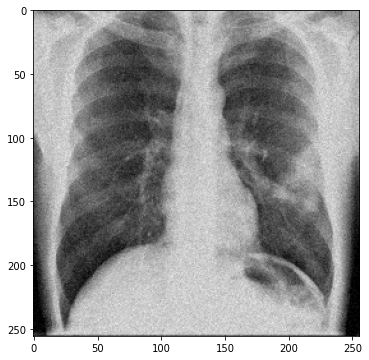

In [ ]:
def noise(image,level):
    """Adds gaussian random noise
    arguments: image, level (level of noise required)
    returns: image with level of gaussian noise added
    """
    temp=image+level*np.random.normal(0, 128, size=(image.shape[0],image.shape[1]))
    #removing negative pixels (set to zero) and normalising back to 255
    regular= temp*(temp>0)
    mynorm=255./np.max(temp)
    #convert back to integer type
    temp = np.around(mynorm*regular).astype('int')
    return(temp)

#add chosen % of noise to the image
amount=0.1 #% of noise required - 0.1 = 10%, 0.05 = 5% etc.
noisy_img=noise(scaled,amount)
#show the transformation
plt.subplots(figsize=(10, 6))
print('--------------------------')
print('Image with %.4f noise'%(amount),':')
print('--------------------------')
plt.imshow(noisy_img, cmap='gray')
plt.show()

## Using Keras' image_data_generator to create a dataset


>  Add channel index at the end of each numpy array

> Define sample variable as one and add dimension to it

> Apply Image data augmentation generator technique to create new dataset (clean and noisy) from the original the images

> Store the dataset as clean and noisy images

> Instanciating the generator

> Add the instances to the storage arrays

> Normalising the images and re-shaping the sets so that they are in the sample, x,y, channel order

In [ ]:
#using Keras' image_data_generator to create a dataset

#add a channel index at the end of each np.array
channel1 = np.expand_dims(scaled, 2)
#define samples variable as being just one image and add a dimension for this
samples= np.expand_dims(channel1, 0)

#image data augmentation generator
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             width_shift_range=0.2,
                             fill_mode='constant',)
datagen.fit(samples)

#create the new dataset including clean, noisy, and very noisy images
maxsize=1000 #required size of the dataset

#storage arrays
clean=[]
noisy=[]

#instanciating the generator
it = datagen.flow(samples, batch_size=1)

#add the instances to storage arrays
for i in range(maxsize):
  new_image=it.next()[0]

# normalising the image
  clean.append(new_image.astype('float32')/255.)
# noise addition to subset of images and normalising 
  noisy.append(noise(new_image[:,:,0],0.1).astype('float32')/255.)

#re-shaping the sets so that they are in the sample, x,y, channel order
created_set=np.reshape(clean, [-1, 256,256, 1])
noisycreated_set=np.reshape(noisy, [-1, 256,256, 1])

### Show outputs of the augmented (new) dataset

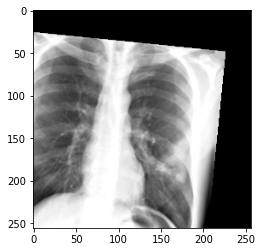

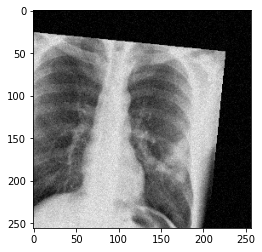

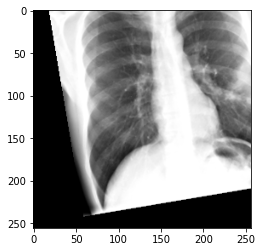

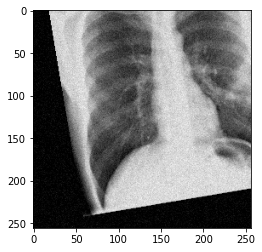

In [ ]:
#show outputs

#image 16, channel 0: clean (augmented) & noisy (augmented)
plt.imshow(created_set[16,:,:,0], cmap='gray')
plt.show()
plt.imshow(noisycreated_set[16,:,:,0], cmap='gray')
plt.show()

#image 97, channel 0: clean (augmented) & noisy (augmented)
plt.imshow(created_set[97,:,:,0], cmap='gray')
plt.show()
plt.imshow(noisycreated_set[97,:,:,0], cmap='gray')
plt.show()

## Splitting the dataset into training and test (70/30)

In [ ]:
#splitting the dataset into training and test (70/30)
X_train, X_test = train_test_split(created_set, test_size = 0.3, random_state = 42)
X_train_noisy, X_test_noisy = train_test_split(noisycreated_set, test_size = 0.3, random_state = 42)

## Define a custom SSIM Loss function

In [ ]:
#define custom SSIM Loss function
def SSIMLoss(y_true, y_pred):
    """Defines a custom loss function for SSIM measurement models
    Arguments: y_true, the true data, and y_pred, calculated prediction
    Returns: SSIMLoss loss function
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Define convolutional denoising autoencoders model

In [ ]:
#network adapted from https://keras.io/examples/vision/autoencoder/

input = Input(shape=channel1.shape)
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
#x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same)(x)
#x = Conv2D(8, (3, 3), activation='relu, padding='same)(x)
#x = MaxPooling2D((2, 2), padding='same)(x)

# Decoder
#x = Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same')(x) 
#reduce strides (2 -> 1) to match removal of max pooling layers on encoder side
x = Conv2DTranspose(16, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer='adam', loss=SSIMLoss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      4624      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 16)     2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 32)     4640      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 1)       289   

### Training of the convolutional autoencoder model

In [ ]:
batch_size = 16

#training the model
history=autoencoder.fit(X_train_noisy, X_train,
                validation_data=(X_test_noisy, X_test),
                epochs=5,
                shuffle=True,
                batch_size=batch_size)

Epoch 1/5
44/44 [==============================] - 628s 14s/step - loss: 0.1811 - val_loss: 0.0780
Epoch 2/5
44/44 [==============================] - 621s 14s/step - loss: 0.0711 - val_loss: 0.0668
Epoch 3/5
44/44 [==============================] - 631s 14s/step - loss: 0.0623 - val_loss: 0.0598
Epoch 4/5
44/44 [==============================] - 634s 14s/step - loss: 0.0583 - val_loss: 0.0575
Epoch 5/5
44/44 [==============================] - 646s 15s/step - loss: 0.0565 - val_loss: 0.0562


## Evaluating the model

### Ploting training and validation with training and validation loss

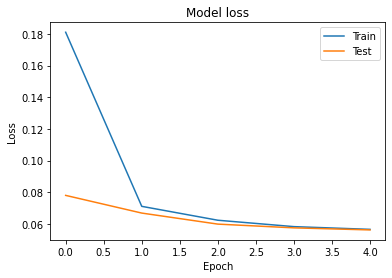

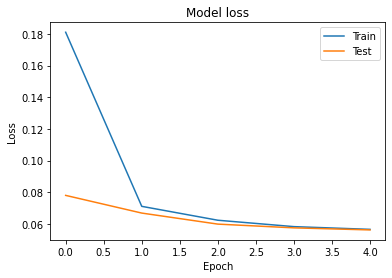

In [ ]:
# Plot model losses

loss_plt = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim([0, 1])
loss_plt



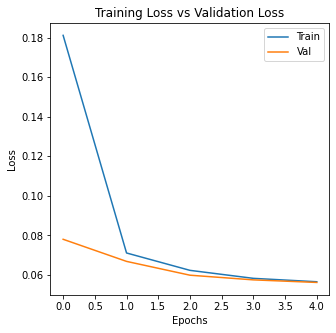

In [ ]:
fig, axs = plt.subplots(figsize=(5,5))

axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.title.set_text('Training Loss vs Validation Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend(['Train','Val'])

### Predict Decoded Image

---------------------
Denoised image output:
---------------------


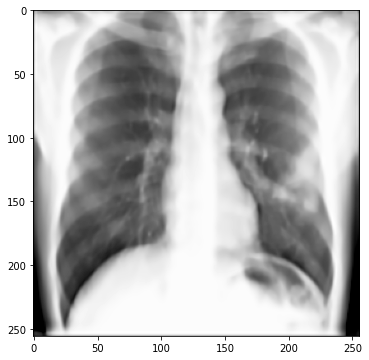

In [ ]:
# Predict AE output from noisy image
noisy_decoded = autoencoder.predict(samples)
plt.subplots(figsize=(10, 6))
print('---------------------')
print('Denoised image output:')
print('---------------------')
plt.imshow(noisy_decoded[0].reshape(256,256), cmap='gray')
plt.show()

### A defined function to qauntify the sharpness of the image

In [ ]:
def sharpness_measure(imageA, imageB, title): 
    #adapted from https://dsp.stackexchange.com/questions/35490/how-to-locally-quantify-the-sharpness-of-an-image
    """function to show the sharpness of 2 side-by-side images as gradient maps
    Arguments: 2 images, title
    Returns: Plots of the 2 images with the difference in contrast (i.e., sharpness) measured by gradient
    """
    imageA_gray = rgb2gray(imageA)
    imageB_gray = rgb2gray(imageB)
    disk_matrix = disk(5) #matrix with a disk shape
    imageA_sharpness = gradient(imageA_gray, disk_matrix)
    imageB_sharpness = gradient(imageB_gray, disk_matrix)
    #Show first image
    plt.imshow(imageA_sharpness, cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.show()
    #show second image
    plt.imshow(imageB_sharpness, cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.show()

### A defined function for the evaluation metrics to measure the performance of the model

In [ ]:
def compare(imageA, imageB, title):

  psnr = peak_signal_noise_ratio(imageA, imageB) #, data_range = 255

  ssim = structural_similarity(imageA, imageB) #, multichannel=True, data_range = 255

  mse = mean_squared_error(imageA, imageB)

  nrmse = normalized_root_mse(imageA, imageB) #,  normalization='euclidean'

  # setup the figure
  fig = plt.figure(title)
  print('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))
  plt.suptitle('PSNR: %.6f, SSIM: %.6f, MSE: %.6f, NRMSE: %.6f' % (psnr, ssim, mse, nrmse))

  # show first image
  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(imageA, cmap='gray')
  plt.axis('off')

  # show the second image
  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(imageB, cmap='gray')
  plt.axis('off')

  # show the images
  plt.show()

  #return psnr, ssim, mse, nrmse

### Normalise the reference, decoded and noisy images again before for comparison.

In [ ]:
#normalising images for comparison
#Normalised_reference = scaled.astype('float32')/255.
#Normalised_decoded = noisy_decoded[0].reshape(256,256)/np.max(noisy_decoded[0])
#Normalised_noisy_original = noisy_img.astype('float32')/255.

#normalising images for comparison
Normalised_reference = scaled.reshape(256,256)/np.max(scaled)
Normalised_decoded = noisy_decoded[0].reshape(256,256)/np.max(noisy_decoded[0])
Normalised_noisy_original = noisy_img.reshape(256,256)/np.max(noisy_img)

### Compare reference (clean) image with the denoised image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


PSNR: 27.074219, SSIM: 0.962332, MSE: 0.001961, NRMSE: 0.059759


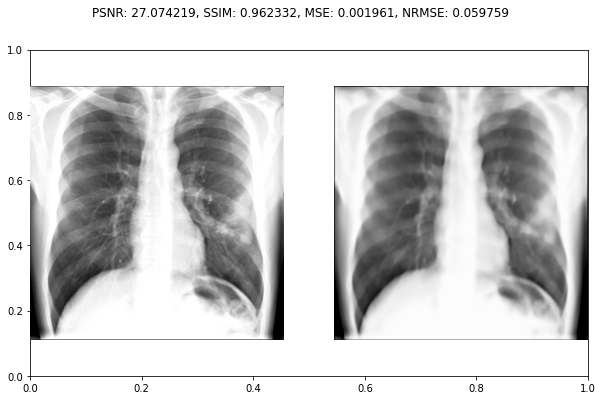

In [ ]:
#compare images clean reference with de-noised
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_decoded,'')
#ideally want mse to be close to 0, ssim to be close to 1 

### Compare reference (clean) image with the noisy image

PSNR: 16.301720, SSIM: 0.775167, MSE: 0.023433, NRMSE: 0.206553


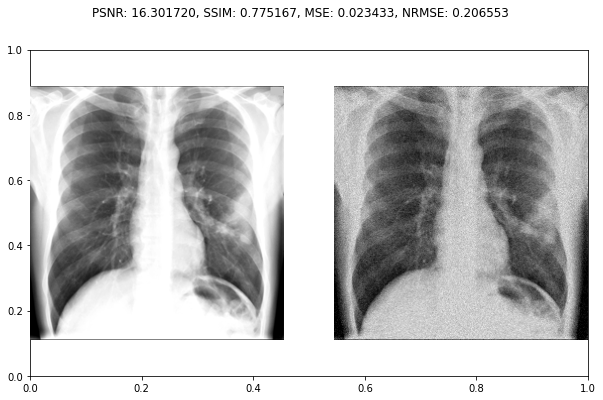

In [ ]:
#Compare images clean reference with noisy original
plt.subplots(figsize=(10, 6))
compare(Normalised_reference, Normalised_noisy_original,'')

### Comparison the sharpness of the image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning

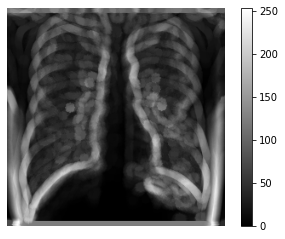

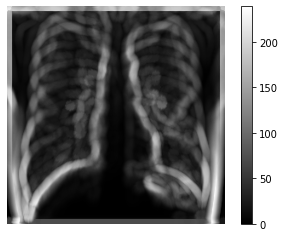

In [ ]:
#Sharpness measure: shows the sharpness of the original non-noisy image vs the output as a gradient
sharpness_measure(Normalised_reference, Normalised_decoded,'') 

## Define median filter function, applied the fuction to the noisy image and display the output (filltered) image

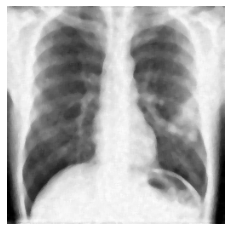

In [ ]:
noisy_image = noisy_img.astype(np.uint8)

median_filter = ndimage.median_filter(noisy_image.reshape(256, 256), size= 5) 

# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(median_filter, cmap='gray')
plt.axis('off')

# show the images
plt.show()

### Normalised the (median) filtered image and compare the reference (clean) image with the (median) filtered image

PSNR: 25.874733, SSIM: 0.930737, MSE: 0.002585, NRMSE: 0.068609


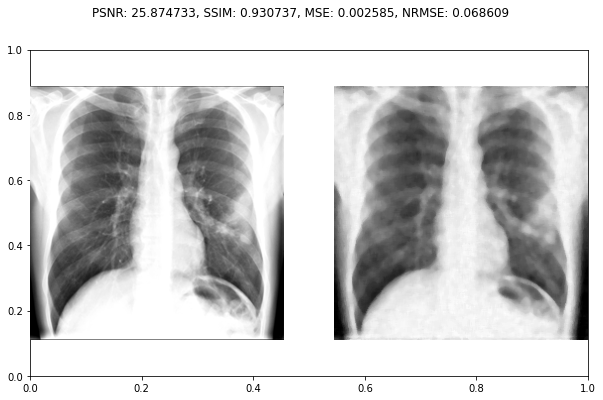

In [ ]:
Normalised_median_filter = median_filter.reshape(256,256)/np.max(median_filter)

#compare images clean reference image with filtered image by median_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_median_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 

## Normalise the noisy image again, defined a bilateal filter function, applied the fuction to the noisy image and display the output (filltered) image

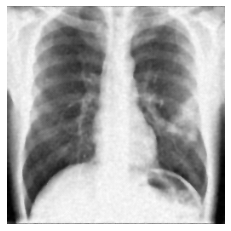

In [ ]:
noisy_image = noisy_img.astype(np.uint8)

bilateral_filter = cv2.bilateralFilter(noisy_image,  5, 50, 50)

# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(bilateral_filter, cmap='gray')
plt.axis('off')

# show the images
plt.show()

### Normalised the (bilatearal) filtered image and compare reference (clean) image with the (bilateral) filtered image

PSNR: 26.754731, SSIM: 0.947333, MSE: 0.002111, NRMSE: 0.061998


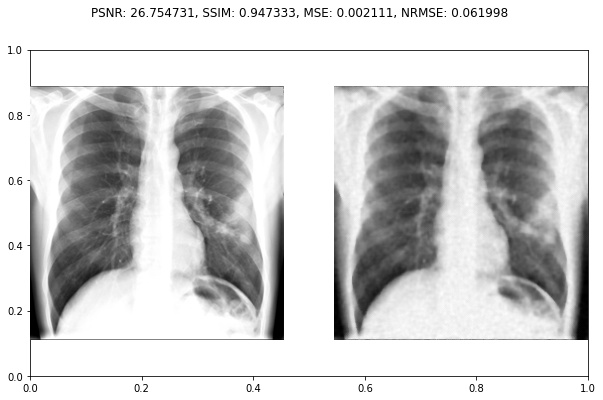

In [ ]:
Normalised_bilateral_filter = bilateral_filter.reshape(256,256)/np.max(bilateral_filter)

#compare images clean reference with filtered image by bilateral_filter
plt.subplots(figsize=(10, 6))
compare (Normalised_reference, Normalised_bilateral_filter,'')
#ideally want mse to be close to 0, ssim to be close to 1 

# Graph Plots

## Graph plots to compare the effectivenes of the models with evlaution metrics

### Plots for effectiveness of the CDAEs

In [ ]:
labels = ['SSIMAda', 'SSIMAda8', 'SSIMAda84', 'BCAda', 'MSAda', 'MSSgd', 'BCSgd', 'BCNada', 'MSNada', 
          'SSIMNada', 'BCRms', 'MSRms', 'SSIMRms']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


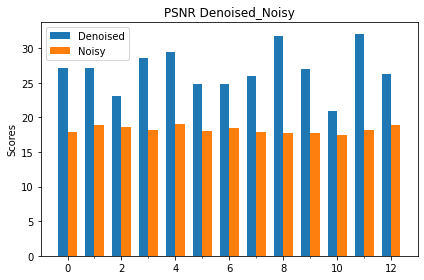

In [ ]:
PSNR_DAEs = [27.174571, 27.199011, 23.123206, 28.655503, 29.440872, 24.799199, 
           24.856751, 25.942762, 31.745618, 26.938065, 20.877046, 32.126407, 26.297147]

PSNR_Noisy = [17.855124, 18.849637, 18.602773, 18.125087, 19.068449, 
              18.011278, 18.398592, 17.903223, 17.696780, 17.752418, 
              17.437843, 18.148986, 18.849898]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, PSNR_DAEs, width, label='Denoised')
bar2 = ax.bar(x + width/2, PSNR_Noisy, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PSNR Denoised_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


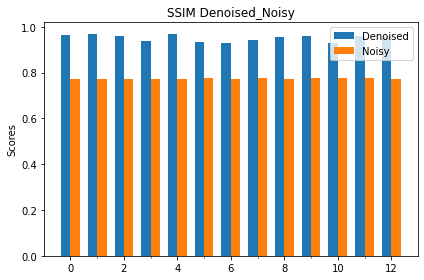

In [ ]:
SSIM_DAEs = [0.963632,0.968753, 0.959962, 0.937164, 0.970995, 0.934561, 
             0.927450, 0.942186, 0.956431, 0.958956, 0.931674, 0.959821, 0.954201]

SSIM_Noisy = [0.773775, 0.772294, 0.770687, 0.773502, 0.771793, 0.775965, 
              0.773467, 0.775134, 0.773753, 0.775246, 0.775955, 0.774587,0.772316,]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, SSIM_DAEs, width, label='Denoised')
bar2 = ax.bar(x + width/2, SSIM_Noisy, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SSIM Denoised_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


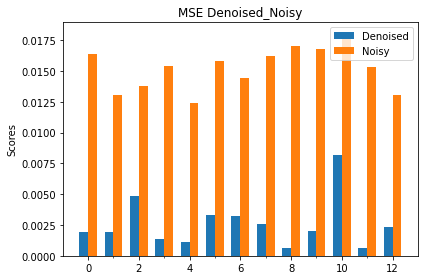

In [ ]:
MSE_DAEs = [0.001917, 0.001906, 0.004872, 0.001363, 0.001137, 0.003312, 0.003268, 
            0.002545, 0.000669, 0.002024, 0.008171, 0.000613, 0.002346]

MSE_Noisy = [0.016387, 0.013033, 0.013795, 0.015399, 0.012392, 0.015808, 
             0.014459, 0.016206, 0.016995, 0.016779, 0.018039, 0.015314, 0.013032]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, MSE_DAEs, width, label='Denoised')
bar2 = ax.bar(x + width/2, MSE_Noisy, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSE Denoised_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


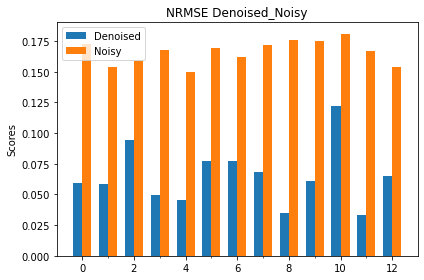

In [ ]:
NRMSE_DAEs = [0.059073, 0.058907, 0.094180, 0.049813, 0.045507, 0.077653, 0.077140,
            0.068074, 0.034901, 0.060704, 0.121973, 0.033404, 0.065352]

NRMSE_Noisy = [0.172727, 0.154041, 0.158482, 0.167442, 0.150209, 0.169650, 0.162251,
             0.171774, 0.175905, 0.174782, 0.181228, 0.166981, 0.154036]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, NRMSE_DAEs, width, label='Denoised')
bar2 = ax.bar(x + width/2, NRMSE_Noisy, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('NRMSE Denoised_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Plots for effectiveness of the Median filters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


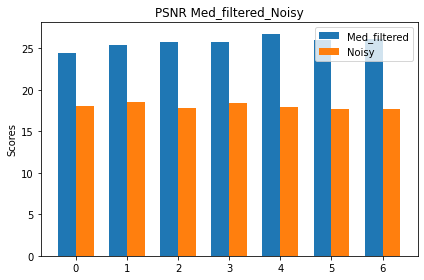

In [ ]:
labels_mf = [ 3, 4, 5, 6, 7, 8, 9]

PSNR_mf = [24.492292, 25.390988, 25.722543, 25.831080, 26.794091, 25.968089, 26.106102]

PSNR_Noisy_mf = [18.011278, 18.500665, 17.855124, 18.398592, 17.903223, 17.696780, 17.752418]


x = np.arange(len(labels_mf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, PSNR_mf, width, label='Med_filtered')
bar2 = ax.bar(x + width/2, PSNR_Noisy_mf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PSNR Med_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


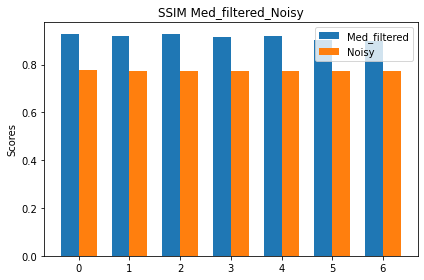

In [ ]:
SSIM_mf = [0.926507, 0.919544, 0.930410, 0.916759, 0.918490, 0.902197, 0.899140]

SSIM_Noisy_mf = [0.775965, 0.772865, 0.773775, 0.773467, 0.775134, 0.773753, 0.775246]


x = np.arange(len(labels_mf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, SSIM_mf, width, label='Med_filtered')
bar2 = ax.bar(x + width/2, SSIM_Noisy_mf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SSIM Med_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


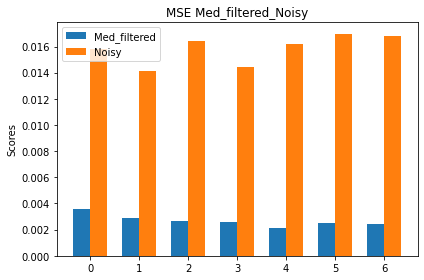

In [ ]:
MSE_mf = [0.003554, 0.002890, 0.002678, 0.002612, 0.002092, 0.002530, 0.002451]

MSE_Noisy_mf = [0.015808, 0.014123, 0.016387, 0.014459, 0.016206, 0.016995, 0.016779]


x = np.arange(len(labels_mf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, MSE_mf, width, label='Med_filtered')
bar2 = ax.bar(x + width/2, MSE_Noisy_mf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSE Med_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Plots for effectiveness of the bilateral filters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


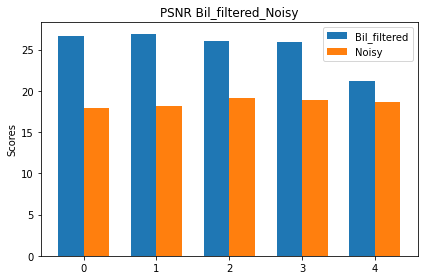

In [ ]:
labels_bf = ['5,50,50', '5,50,100', '5,100,150', '10,150,150', '2,20,50']

PSNR_bf = [26.631378, 26.943294, 25.988515, 25.955893, 21.200395]

PSNR_Noisy_bf = [17.855124, 18.125087, 19.068449, 18.849637, 18.602773]


x = np.arange(len(labels_bf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, PSNR_bf, width, label='Bil_filtered')
bar2 = ax.bar(x + width/2, PSNR_Noisy_bf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('PSNR Bil_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


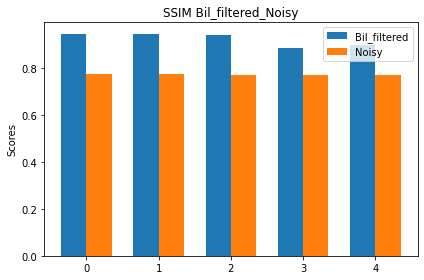

In [ ]:
SSIM_bf = [0.947378, 0.947731, 0.942286, 0.885126, 0.899258]

SSIM_Noisy_bf = [0.773775, 0.773502, 0.771793, 0.772294, 0.770687]


x = np.arange(len(labels_bf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, SSIM_bf, width, label='Bil_filtered')
bar2 = ax.bar(x + width/2, SSIM_Noisy_bf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('SSIM Bil_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


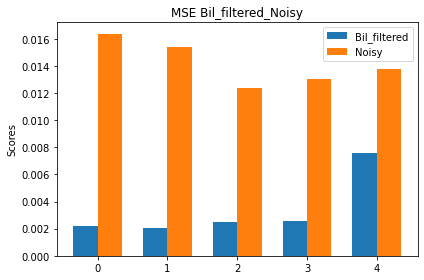

In [ ]:
MSE_bf = [0.002172, 0.002021, 0.002519, 0.002538, 0.007585]

MSE_Noisy_bf = [0.016387, 0.015399, 0.012392, 0.013033, 0.013795]


x = np.arange(len(labels_bf))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, MSE_bf, width, label='Bil_filtered')
bar2 = ax.bar(x + width/2, MSE_Noisy_bf, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('MSE Bil_filtered_Noisy')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

## Graph plots of evaluation metrics for denoised images with CDAEs

In [ ]:
# initialize data of lists.
data = {
    'Noise_level': [2.5, 5.0, 7.5, 10.0, 15.0],
    'PSNR_deniosed': [27.846758, 28.007638, 26.357736, 25.895622, 23.637344],
    'SSIM_deniosed': [0.987084, 0.976663, 0.969121, 0.959478, 0.962026],
    'MSE_denoised' : [0.001642, 0.001582, 0.002313, 0.002573, 0.004328],
    'NRMSE_denoised': [0.054674, 0.053671, 0.064898, 0.068444, 0.088767]
    }


# Create DataFrame
df_deniosed = pd.DataFrame(data)

print(df_deniosed)

   Noise_level  PSNR_deniosed  SSIM_deniosed  MSE_denoised  NRMSE_denoised
0          2.5      27.846758       0.987084      0.001642        0.054674
1          5.0      28.007638       0.976663      0.001582        0.053671
2          7.5      26.357736       0.969121      0.002313        0.064898
3         10.0      25.895622       0.959478      0.002573        0.068444
4         15.0      23.637344       0.962026      0.004328        0.088767


Text(0.5, 1.0, 'Noise-PSNR for Denoised AE')

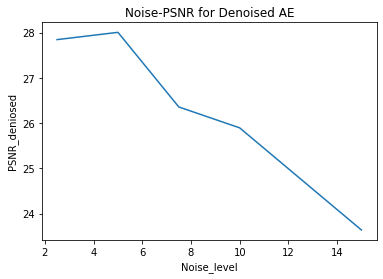

In [ ]:
sns.lineplot(data= df_deniosed, x = "Noise_level", y = "PSNR_deniosed")
plt.title("Noise-PSNR for Denoised AE")

Text(0.5, 1.0, 'Noise-SSIM for Denoised AE')

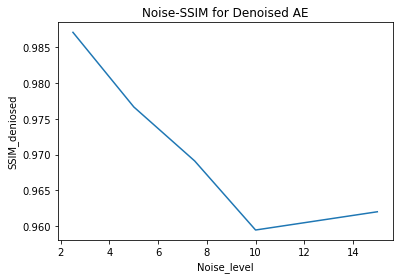

In [ ]:
sns.lineplot(data= df_deniosed, x = "Noise_level", y = "SSIM_deniosed")
plt.title("Noise-SSIM for Denoised AE")

Text(0.5, 1.0, 'Noise-MSE for Denoised AE')

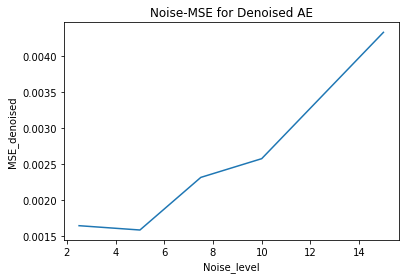

In [ ]:
sns.lineplot(data= df_deniosed, x = "Noise_level", y = "MSE_denoised")
plt.title("Noise-MSE for Denoised AE")

Text(0.5, 1.0, 'Noise-NRMSE for Denoised AE')

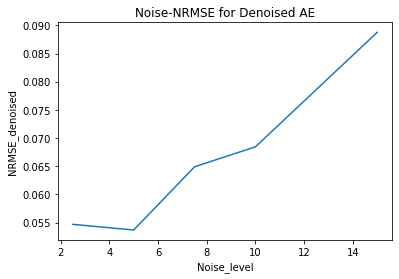

In [ ]:
sns.lineplot(data= df_deniosed, x = "Noise_level", y = "NRMSE_denoised")
plt.title("Noise-NRMSE for Denoised AE")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e2098f990>,
      dtype=object)

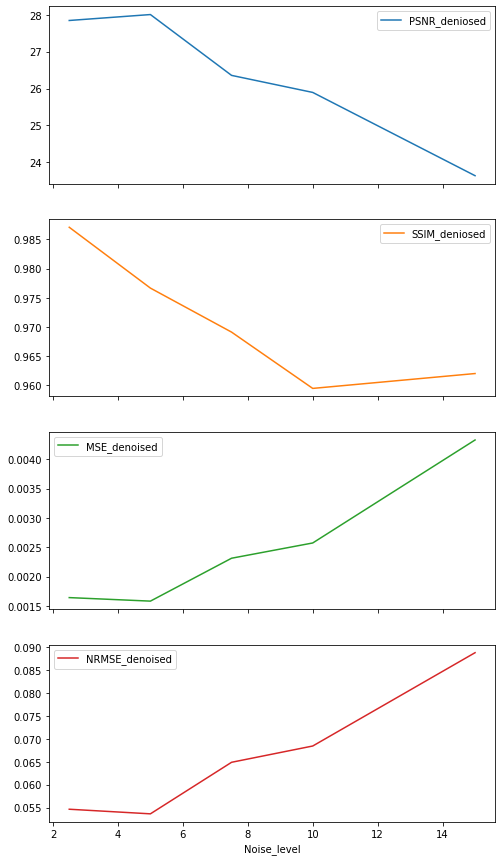

In [ ]:
df_deniosed.plot.line(x = "Noise_level", subplots = True, figsize=(8, 15))

## *Graph plots of evaluation metrics for filtered images with median filters*

In [ ]:
# initialize data of lists.
data = {
    'Noise_level': [2.5, 5.0, 7.5, 10.0, 15.0],
    'PSNR_medianfilter': [28.458272, 27.970209, 27.109374, 26.308966, 23.885273],
    'SSIM_medianfilter': [0.957570, 0.950549, 0.941518, 0.929944, 0.907526],
    'MSE_medianfilter' : [0.001426, 0.001596, 0.001946, 0.002339, 0.004088],
    'NRMSE_medianfilter': [0.050957, 0.053902, 0.059518, 0.065263, 0.086269]
    }


# Create DataFrame
df_medianfilter = pd.DataFrame(data)

print(df_medianfilter)

   Noise_level  PSNR_medianfilter  SSIM_medianfilter  MSE_medianfilter  \
0          2.5          28.458272           0.957570          0.001426   
1          5.0          27.970209           0.950549          0.001596   
2          7.5          27.109374           0.941518          0.001946   
3         10.0          26.308966           0.929944          0.002339   
4         15.0          23.885273           0.907526          0.004088   

   NRMSE_medianfilter  
0            0.050957  
1            0.053902  
2            0.059518  
3            0.065263  
4            0.086269  


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e208154d0>,
      dtype=object)

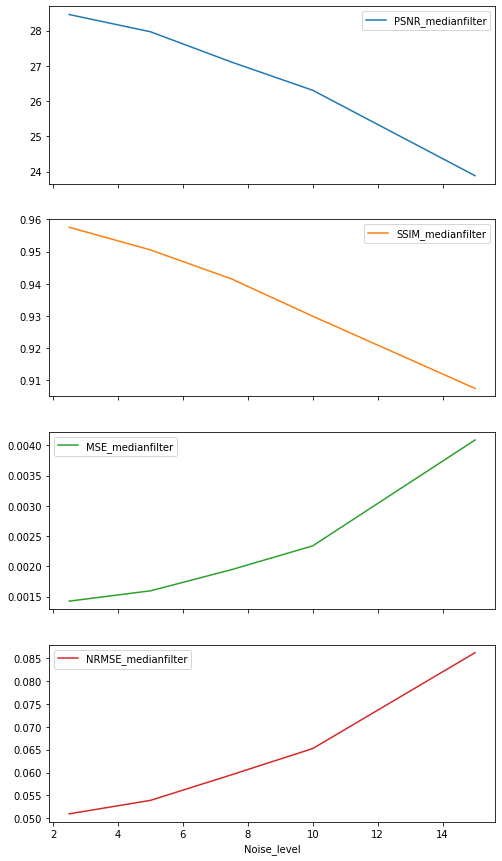

In [ ]:
df_medianfilter.plot.line(x = "Noise_level", subplots = True, figsize=(8, 15))

Text(0.5, 1.0, 'Noise-PSNR for Median filter')

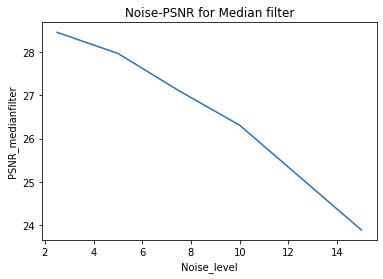

In [ ]:
sns.lineplot(data= df_medianfilter, x = "Noise_level", y = "PSNR_medianfilter")
plt.title("Noise-PSNR for Median filter")

Text(0.5, 1.0, 'Noise-SSIM for Median filter')

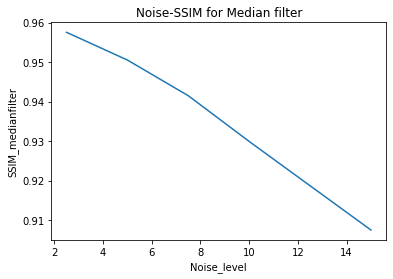

In [ ]:
sns.lineplot(data= df_medianfilter, x = "Noise_level", y = "SSIM_medianfilter")
plt.title("Noise-SSIM for Median filter")

Text(0.5, 1.0, 'Noise-MSE for Median filter')

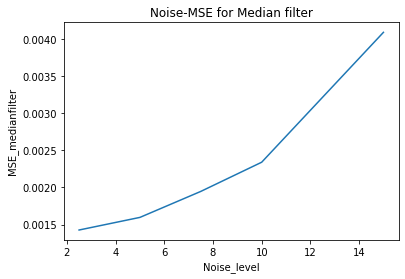

In [ ]:
sns.lineplot(data= df_medianfilter, x = "Noise_level", y = "MSE_medianfilter")
plt.title("Noise-MSE for Median filter")

Text(0.5, 1.0, 'Noise-NRMSE for Median filter')

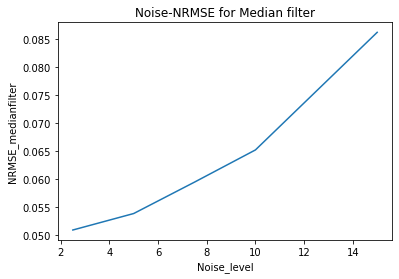

In [ ]:
sns.lineplot(data= df_medianfilter, x = "Noise_level", y = "NRMSE_medianfilter")
plt.title("Noise-NRMSE for Median filter")

## *Graph plots of evaluation metrics for filtered images with bilateral filters*

In [ ]:
# initialize data of lists.
data = {
    'Noise_level': [2.5, 5.0, 7.5, 10.0, 15.0],
    'PSNR_bilfilter': [34.176021, 31.036360, 28.950836, 26.028503, 23.662717],
    'SSIM_bilfilter': [0.973177, 0.967538, 0.958485, 0.946104, 0.915196],
    'MSE_bilfilter' : [0.000382, 0.000788, 0.001273, 0.002495, 0.004303],
    'NRMSE_bilfilter': [0.026383, 0.037870, 0.048148, 0.067405, 0.088508]
    }


# Create DataFrame
df_bilfilter = pd.DataFrame(data)

print(df_bilfilter)

   Noise_level  PSNR_bilfilter  SSIM_bilfilter  MSE_bilfilter  NRMSE_bilfilter
0          2.5       34.176021        0.973177       0.000382         0.026383
1          5.0       31.036360        0.967538       0.000788         0.037870
2          7.5       28.950836        0.958485       0.001273         0.048148
3         10.0       26.028503        0.946104       0.002495         0.067405
4         15.0       23.662717        0.915196       0.004303         0.088508


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e1c659fd0>,
      dtype=object)

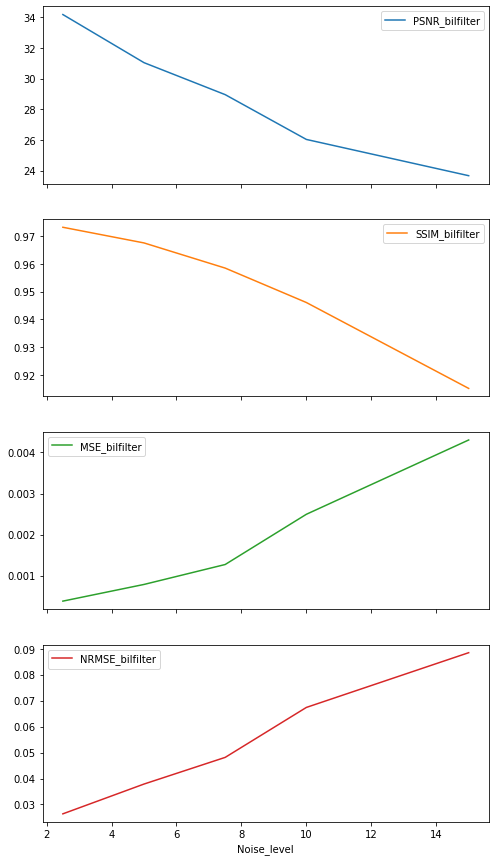

In [ ]:
df_bilfilter.plot.line(x = "Noise_level", subplots = True, figsize=(8, 15))

Text(0.5, 1.0, 'Noise-PSNR for Bilateral filter')

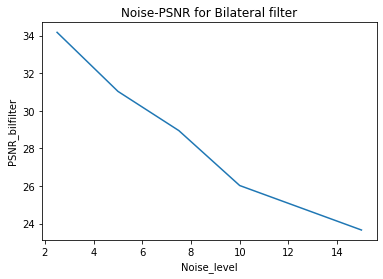

In [ ]:
sns.lineplot(data= df_bilfilter, x = "Noise_level", y = "PSNR_bilfilter")
plt.title("Noise-PSNR for Bilateral filter")

Text(0.5, 1.0, 'Noise-SSIM for Bilateral filter')

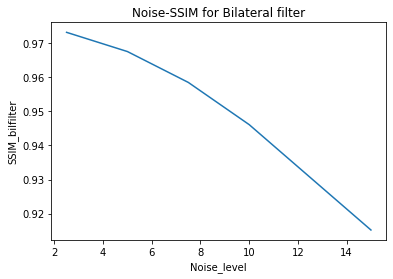

In [ ]:
sns.lineplot(data= df_bilfilter, x = "Noise_level", y = "SSIM_bilfilter")
plt.title("Noise-SSIM for Bilateral filter")

Text(0.5, 1.0, 'Noise-MSE for Bilateral filter')

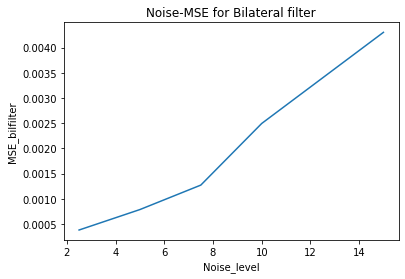

In [ ]:
sns.lineplot(data= df_bilfilter, x = "Noise_level", y = "MSE_bilfilter")
plt.title("Noise-MSE for Bilateral filter")

Text(0.5, 1.0, 'Noise-NRMSE for Bilateral filter')

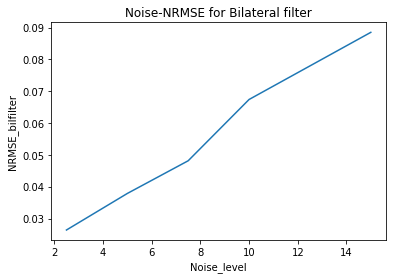

In [ ]:
sns.lineplot(data= df_bilfilter, x = "Noise_level", y = "NRMSE_bilfilter")
plt.title("Noise-NRMSE for Bilateral filter")